In [ ]:
"""test a trained xgb model on a holdout portion of the time series for each produce item
output results as the MAPE for each item
"""

In [340]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from xgboost.sklearn import XGBRegressor  
import pickle
import math
sns.set_style("darkgrid")

In [341]:
def generate_predict_start_dates(start_date, end_date, train_length, test_length, window_step):
    # generates a list of dates to start predicting from given a master start date/end date, 
    # as well as a training set length, test length, and step between each train+test pair.
    train_time = pd.to_timedelta(pd.np.ceil(train_length), unit="D")
    test_time = pd.to_timedelta(pd.np.ceil(test_length), unit="D")
    window_time = pd.to_timedelta(pd.np.ceil(window_step), unit='D')
    output_dates = [pd.to_datetime(start_date) + train_time]
    most_recent_date = pd.to_datetime(start_date) + train_time
    while most_recent_date + test_time <= pd.to_datetime(end_date):
        output_dates.append(most_recent_date + window_time)
        most_recent_date = most_recent_date + window_time
    return(output_dates)

In [342]:
def read_trimmed_data(city, veggie, data_dir):
    # reads in cleaned .csv data for one city and veggie, returns
    output_data = pd.read_csv(data_dir+veggie+'_'+city+'_TRIM.csv')
    output_data.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)
    output_data['Date'] = pd.to_datetime(output_data['Date'])
    output_data = output_data.sort_values(by='Date')
    output_data = output_data.reset_index(drop=True)
    #output_data = normalize_price(output_data)
    return output_data

In [343]:
def normalize_price(input_data): 
    # not used here
    input_data['Average Price'] = (input_data['Average Price'] - input_data['Average Price'].median())/input_data['Average Price'].std()
    return input_data

In [344]:
def nearest_date(dates, targdate):
    # finds nearest date to targdate in list of dates
    diff = abs(dates - targdate)
    nearest = dates.iloc[diff.idxmin]
    timedelta = abs(nearest - targdate)
    return nearest, timedelta

In [345]:
def get_train_test(veggie_data, start_date, train_days, predict_days):
    # given a start date and data, constructs a training and test set
    all_dates = pd.to_datetime(veggie_data['Date'])
    train_time = pd.to_timedelta(pd.np.ceil(train_days), unit="D")
    test_time = pd.to_timedelta(pd.np.ceil(predict_days), unit="D")
    start_date_train = start_date - train_time
    nearest_date_train, deltatrain = nearest_date(all_dates, start_date_train)
    end_date_test = start_date + test_time
    nearest_date_test, deltatest = nearest_date(all_dates, end_date_test)
    training_set = veggie_data[(veggie_data['Date'] >= nearest_date_train) & (veggie_data['Date'] < start_date)]
    test_set = veggie_data[(veggie_data['Date'] >= start_date) & (veggie_data['Date'] <= nearest_date_test)]
    return training_set, test_set

In [346]:
def build_features(input_data, start_date, test_days, train_days):
    # feature engineering
    features = []
    # convert times to deltas
    train_time = pd.to_timedelta(pd.np.ceil(train_days), unit="D")
    test_time = pd.to_timedelta(pd.np.ceil(test_days), unit="D")
    one_year = pd.to_timedelta(pd.np.ceil(365), unit='D')
    ten = pd.to_timedelta(pd.np.ceil(14), unit='D')
    twenty = pd.to_timedelta(pd.np.ceil(14), unit='D')
    thirty = pd.to_timedelta(pd.np.ceil(30), unit='D')
    sixty = pd.to_timedelta(pd.np.ceil(60), unit='D')
    ninety = pd.to_timedelta(pd.np.ceil(90), unit='D')
    recent_dates = [ten, twenty, thirty, sixty, ninety, one_year]
    
    featurenames = []
    
    # convert pricing data to pct_change
    pct_changes = input_data['Average Price'].pct_change()
    pct_changes = pd.concat([input_data['Date'], pct_changes], axis=1)
    # replace 0s with nans for now
    pct_changes['Average Price'] = pct_changes['Average Price'].replace(0, np.NaN)
    # compute historical averages and stds
    num_years = train_days // 365
    
    alt_tickers = ['SYY', 'FDP', 'SENEA', 'CAG', 'KR']
    
    for y in range(num_years):
        historical_prices = input_data[(input_data['Date'] >= (start_date-(y+1)*one_year)) & (input_data['Date'] <= (start_date-(y+1)*one_year + test_time))]
        features.append(historical_prices['Average Price'].mean())
        featurenames.append(str(y)+'_yearago_ave')
        features.append(historical_prices['Average Price'].std())
        featurenames.append(str(y)+'_yearago_std')

        # now append stock ticker/oil (external data):
        for t in alt_tickers:
            features.append(historical_prices[t].mean())
            featurenames.append(t+'_'+str(y)+'_yearago_ave')
            
        features.append(historical_prices['POILWTIUSDM'].mean())
        featurenames.append('oil_'+str(y)+'_yearago_ave')

        historical_pct = pct_changes[(pct_changes['Date'] >= (start_date-(y+1)*one_year)) & (pct_changes['Date'] <= (start_date-(y+1)*one_year + test_time))]
        features.append(historical_pct['Average Price'].mean())
        featurenames.append(str(y)+'_yearago_ave_pct')
        features.append(historical_pct['Average Price'].std())
        featurenames.append(str(y)+'_yearago_std_pct')

        # now append stock ticker/oil (external data):
        for t in alt_tickers:
            features.append(historical_prices[t].pct_change().mean())
            featurenames.append(t+'_'+str(y)+'_yearago_ave_pct')

    # now do last 14, 30, etc. day features avg/std
    for d in recent_dates:
        recent_prices = input_data[(input_data['Date'] >= (start_date - d)) & (input_data['Date'] <= (start_date))]
        features.append(recent_prices['Average Price'].mean())
        featurenames.append(str(d)+'_recent_ave')
        features.append(recent_prices['Average Price'].std())
        featurenames.append(str(d)+'_recent_std')
        features.append(recent_prices['Date'].dt.month.mean())
        featurenames.append('ave_date')
        
        #subloop to compute slopes
        less_recent_prices = input_data[(input_data['Date'] >= (start_date - 2*d)) & (input_data['Date'] <= (start_date-d))]
        features.append((recent_prices['Average Price'].mean()-less_recent_prices['Average Price'].mean())/recent_prices['Average Price'].mean())
        featurenames.append(str(d)+'_recent_slope')
        # now append stock ticker/oil (external data):
        for t in alt_tickers:
            features.append(recent_prices[t].mean())
            featurenames.append(t+'_'+str(d)+'_recent_ave')
        
        recent_pct = pct_changes[(pct_changes['Date'] >= (start_date - d)) & (pct_changes['Date'] <= (start_date))]
        features.append(recent_pct['Average Price'].mean())
        featurenames.append(str(d)+'_recent_ave_pct')

        features.append(recent_pct['Average Price'].std())
        featurenames.append(str(d)+'_recent_ave_pct')
        
        # now append stock ticker/oil (external data):
        for t in alt_tickers:
            features.append(recent_prices[t].pct_change().mean())
            featurenames.append(t+'_'+str(d)+'_recent_ave_pct')
            
    return features, featurenames

In [347]:
def build_corr_features(input_data, start_date, test_days, train_days, vname):
    # feature engineering
    features = []
    featurenames = []
    # convert times to deltas
    train_time = pd.to_timedelta(pd.np.ceil(train_days), unit="D")
    test_time = pd.to_timedelta(pd.np.ceil(test_days), unit="D")
    one_year = pd.to_timedelta(pd.np.ceil(365), unit='D')
    fourteen = pd.to_timedelta(pd.np.ceil(14), unit='D')
    thirty = pd.to_timedelta(pd.np.ceil(30), unit='D')
    recent_dates = [fourteen, thirty]
    # convert pricing data to pct_change
    pct_changes = input_data['Average Price'].pct_change()
    pct_changes = pd.concat([input_data['Date'], pct_changes], axis=1)
    # replace 0s with nans for now
    pct_changes['Average Price'] = pct_changes['Average Price'].replace(0, np.NaN)
    # compute historical averages and stds
    num_years = train_days // 365
    for y in range(num_years):
        historical_prices = input_data[(input_data['Date'] >= (start_date-(y+1)*one_year)) & (input_data['Date'] <= (start_date-(y+1)*one_year + test_time))]
        features.append(historical_prices['Average Price'].mean())
        featurenames.append(vname+'_'+str(y)+'_ago_ave')
    # now do last 14, 30, day features avg/std
    for d in recent_dates:
        recent_prices = input_data[(input_data['Date'] >= (start_date - d)) & (input_data['Date'] <= (start_date))]
        features.append(recent_prices['Average Price'].mean())
        featurenames.append(vname+'_'+str(d)+'_recent_ave')
    return features, featurenames

In [348]:
def build_set(veggie_data, start_dates, train_days, predict_days, correlations, city, data_dir):
    # embedding the correlation data read probably isn't super optimal in this function but it will have to do for now
    # builds a set of train/test splits
    training_features = []
    predicting_set = []
    counter=0
    all_featnames = []
    for i in start_dates:
        train, pred = get_train_test(veggie_data, i, train_days, predict_days)
        predicting_set.append(pred['Average Price'].mean())
        features, all_featnames = build_features(train, i, predict_days, train_days)
        # roll forward previous set's features if they don't exist in current set
        for f in range(len(features)):
            if counter>0 and math.isnan(f):
                features[f] = training_features[-1][f]
        # remove lingering nans
        features = [0.0 if math.isnan(x) else x for x in features]
        training_features.append(features)
        counter+=1
    # now do the correlation data - hacking this in
    for cor in correlations:
        corr_data = read_trimmed_data(city, cor, data_dir)
        counter=0
        fnames = []
        for i in start_dates:
            # some wheel-spinning here but can fix later
            train_pred = get_train_test(corr_data, i, train_days, predict_days)
            features, fnames = build_corr_features(train, i, predict_days, train_days, cor)
            # roll forward previous set's features if they don't exist in current set
            for f in range(len(features)):
                if counter>0 and math.isnan(f):
                    features[f] = training_features[-1][len(training_features[counter])+f]
            # remove nans, replace with 0
            features = [0.0 if math.isnan(x) else x for x in features]
            training_features[counter] = training_features[counter]+features
            counter+=1
        all_featnames = all_featnames + fnames
    # remove any places where there isn't any prediction due to no data
    training_features = [training_features[x] for x in range(len(training_features)) if (math.isnan(predicting_set[x]) != True)]
    predicting_set = [predicting_set[x] for x in range(len(predicting_set)) if (math.isnan(predicting_set[x]) != True)]
    return training_features, predicting_set, all_featnames

In [349]:
def read_stored_model(city, veggie, directory):
    # read in saved xgb model
    loaded_model = pickle.load(open(directory+city+'_'+veggie+'_model', "rb"))
    return loaded_model

In [350]:
def booster_model_predictions(input_features, targets, veggie, city, modeldir, veggiedir):
    # run predict using a loaded xgb model and the train/test split sets
    model = read_stored_model(city, veggie, modeldir)
    predictions = []
    for i in range(len(input_features)):
        predictions.append(model.predict(input_features[i])[0])
    pct_misses = abs((pd.DataFrame(predictions) - pd.DataFrame(targets)) / pd.DataFrame(targets))
    return pct_misses.mean()
    

In [351]:
def plot_pct_misses(miss_array, city, title):
    # plot barchart of percent misses
    plt.rcParams['xtick.labelsize']=14
    plt.rcParams['ytick.labelsize']=14
    plt.figure(figsize=(20,5))
    plt.xticks(rotation=90)
    
    xpos = np.arange(len(miss_array['Item']))                
    plot = plt.bar(xpos, miss_array['PCT Miss'])
    plt.xticks(xpos, miss_array['Item'])
    plt.xlabel('Year', fontsize=14)
    plt.ylabel('PCT Miss', fontsize=14)
    plt.title(title+'_'+city)

    plt.savefig(title+'_'+city+'_pctmiss.png', format='png', bbox_inches='tight')

In [352]:
test_start_date = '20141201'
test_end_date = '20180531'

train_start_date = '20070601'
train_end_date = '20170530'

feature_length_days = 365*3
test_length_days = 90
window_step = 15
datadir = './trimmed_data_and_plots/'
modeldir = './saved_xgb_models/'

# load the correlation_data
correlation_dir = './'

#cities = ['NEW+YORK', 'LOS+ANGELES']
cities = ['LOS+ANGELES']
#veggienames = ['CARROTS']
veggienames = ['APPLES','APRICOTS','ASPARAGUS','AVOCADOS','BANANAS','BEANS','BEETS','BLACKBERRIES','BLUEBERRIES','BROCCOLI','CABBAGE','CANTALOUPS','CARROTS','CAULIFLOWER','CELERY','CHERRIES','CLEMENTINES', 'CUCUMBERS','ENDIVE','GARLIC','GINGER+ROOT','GRAPEFRUIT','GRAPES','HONEYDEWS','KIWIFRUIT','LEMONS','LETTUCE%2C+ICEBERG','LETTUCE%2C+ROMAINE','LETTUCE%2C+RED+LEAF','LETTUCE%2C+GREEN+LEAF', 'LIMES','NECTARINES','OKRA','ORANGES','PEACHES','PEARS','PEAS+GREEN','PEPPERS%2C+BELL+TYPE','PINEAPPLES','PLUMS','POTATOES','RADISHES','RASPBERRIES','RHUBARB','SPINACH','SQUASH','STRAWBERRIES']
#veggienames = ['CARROTS', 'PEACHES', 'APPLES', 'CELERY', 'ORANGES', 'BRUSSELS+SPROUTS']
#veggienames = ['BRUSSELS+SPROUTS']



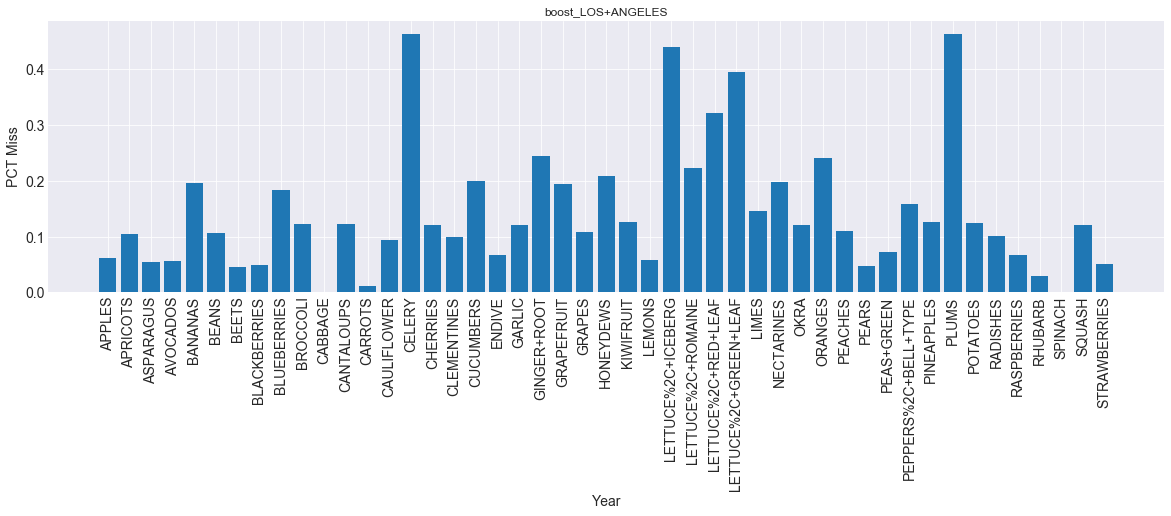

In [353]:
start_dates = generate_predict_start_dates(test_start_date, test_end_date, feature_length_days, test_length_days, window_step)

labels = ['Item', 'PCT Miss']
# loop over cities, veggies and run xgb on each
for c in cities:
    
    output_stats = []
    correlation_list = pd.read_csv(correlation_dir+c+'_correlations.csv')
    
    for v in veggienames:
        vcorrs = correlation_list[v+'_norm']
        current_veggie = read_trimmed_data(c, v, datadir)
        input_features, output_targets, _ = build_set(current_veggie, start_dates, feature_length_days, test_length_days, vcorrs, c, datadir)
        pct_misses = booster_model_predictions(input_features, output_targets, v, c, modeldir, datadir)
        # handle no pct_misses because missing data
        if len(pct_misses)==1:
            output_stats.append((v, pct_misses[0]))
        else:
            output_stats.append((v, 0.0))
    summary_hist = pd.DataFrame.from_records(output_stats, columns=labels)
    summary_hist.to_csv(c + '_boost_output.csv')
    plot_pct_misses(summary_hist, c, 'boost')





        